In [ ]:
"""
To prepare the starter code, copy this file over to decision_tree_starter.py
and go through and handle all the inline TODO(cathywu)s.
"""
from collections import Counter

import numpy as np
from numpy import genfromtxt
import scipy.io
from scipy import stats
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score
import pandas as pd
from pydot import graph_from_dot_data
import io


import random
random.seed(246810)
np.random.seed(246810)

eps = 1e-5  # a small number


class DecisionTree:

    def __init__(self, max_depth=5, feature_labels=None):
        self.max_depth = max_depth
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes

    # entropy = -p(Y=y1)log2(y1)--p(Y=y2)log2(y2)- ......
    @staticmethod
    def entropy(y):
        counts = Counter(y) # example {1:2, 0:6}
        entropy = 0
        for count in counts.values():
            probability = count / len(y)
            entropy -= probability * np.log2(probability)
        return entropy


    @staticmethod
    def information_gain(X, y, thresh):
        entropy = DecisionTree.entropy(y)

        y_left = y[X < thresh]
        y_right = y[X >= thresh]

        if len(y_left) == 0 or len(y_right) == 0:
          return 0

        p_left = len(y_left)/len(y)
        p_right = len(y_right)/len(y)

        conditional_entropy = p_left * DecisionTree.entropy(y_left) + p_right * DecisionTree.entropy(y_right)
        information_gain = entropy - conditional_entropy

        return information_gain

    @staticmethod
    def gini_impurity(X, y, thresh):
        # OPTIONAL
        pass

    @staticmethod
    def gini_purification(X, y, thresh):
        # OPTIONAL
        pass

    def split(self, X, y, feature_idx, thresh):
        """
        Split the dataset into two subsets, given a feature and a threshold.
        Return X_0, y_0, X_1, y_1
        where (X_0, y_0) are the subset of examples whose feature_idx-th feature
        is less than thresh, and (X_1, y_1) are the other examples.
        """
        #feature = X[feature_idx]
        ind_left = np.where(X[:, feature_idx] < thresh)[0]
        ind_right = np.where(X[:, feature_idx]>= thresh)[0]

        X_left = X[ind_left]
        X_right = X[ind_right]
        y_left = y[ind_left]
        y_right = y[ind_right]

        return X_left,y_left,X_right,y_right

    def find_best_thresh_feature(self, X, y):

        best_gain = -float('inf')
        best_feature = None
        best_thresh = None

        for feature_idx in range(X.shape[1]):
            fearure_values = X[:,feature_idx]
            unique_values = np.unique(fearure_values)

            if len(unique_values) <= 1:
                continue

            for i in range(len(unique_values) - 1):
                thresh = (unique_values[i] + unique_values[i+1]) / 2
                gain = self.information_gain(fearure_values, y, thresh) # for this set of feature values calculate the gain

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_thresh = thresh
        return best_feature, best_thresh, best_gain

    def fit(self, X, y):

        if (self.max_depth <= 0) or len(np.unique(y)) == 1 :
            self.pred = stats.mode(y, keepdims=True)[0][0]
            self.labels = y
            self.split_idx = 0
            self.thresh = 0
            return self

        self.split_idx, self.thresh, gain = self.find_best_thresh_feature(X, y)


        if self.split_idx is None or gain < eps:
            self.pred = stats.mode(y, keepdims=True)[0][0]
            self.labels = y
            return self

        X_left, y_left, X_right, y_right = self.split(X, y, self.split_idx, self.thresh)



        if len(y_left) == 0 or len(y_right) == 0:
            self.pred = stats.mode(y, keepdims=True)[0][0]
            self.labels = y
            return self
         # create new trees for childeren
        self.left = DecisionTree(max_depth = self.max_depth - 1, feature_labels = self.features)
        self.right = DecisionTree(max_depth = self.max_depth - 1, feature_labels = self.features)

        self.left.fit(X_left, y_left)
        self.right.fit(X_right, y_right)
        return self



    def predict(self, X):
        if self.pred is not None:
            return self.pred

        if X[self.split_idx] < self.thresh:
            return self.left.predict(X)
        else:
            return self.right.predict(X)

    def _to_graphviz(self, node_id):
        if self.max_depth == 0:
            return f'{node_id} [label="Prediction: {self.pred}\nSamples: {self.labels.size}"];\n'
        else:
            graph = f'{node_id} [label="{self.features[self.split_idx]} < {self.thresh:.2f}"];\n'
            left_id = node_id * 2 + 1
            right_id = node_id * 2 + 2
            if self.left is not None:
                graph += f'{node_id} -> {left_id} [label="yes"];\n'
                graph += self.left._to_graphviz(left_id)
            if self.right is not None:
                graph += f'{node_id} -> {right_id} [label="no"];\n'
                graph += self.right._to_graphviz(right_id)
            return graph

    def to_graphviz(self):
        graph = "digraph Tree {\nnode [shape=box];\n"
        graph += self._to_graphviz(0)
        graph += "}\n"
        return graph

    def __repr__(self):
        if self.max_depth == 0:
            return "%s (%s)" % (self.pred, self.labels.size)
        else:
            return "[%s < %s: %s | %s]" % (self.features[self.split_idx],
                                           self.thresh, self.left.__repr__(),
                                           self.right.__repr__())


class BaggedTrees(BaseEstimator, ClassifierMixin):

    def __init__(self, params=None, n=200):
        if params is None:
            params = {}
        self.params = params
        self.n = n
        self.decision_trees = [
            DecisionTreeClassifier(random_state=i, **self.params)
            for i in range(self.n)
        ]

    def fit(self, X, y):
        for tree in self.decision_trees:
            number_of_data = X.shape[0]
            idex = np.random.choice(number_of_data, number_of_data, replace=True)
            X = X[idex, :]
            y = y[idex]
            tree.fit(X, y)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.decision_trees])
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
        #predictions = np.array([tree.predict(X) for tree in self.decision_trees])
        #return np.mean(predictions, axis=0)


class RandomForest(BaggedTrees):

    def __init__(self, params=None, n=200, m=1):
        if params is None:
            params = {}
        params['max_features'] = m
        self.m = m
        super().__init__(params=params, n=n)


class BoostedRandomForest(RandomForest):
    # OPTIONAL
    def fit(self, X, y):
        # TODO
        pass

    def predict(self, X):
        # TODO
        pass


def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    # Temporarily assign -1 to missing data
    data[data == b''] = '-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():
            if term[0] == b'-1':
                continue
            if term[-1] <= min_freq:
                break
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(float))
        data[:, col] = '0'
    onehot_encoding = np.array(onehot_encoding).T
    data = np.hstack(
        [np.array(data, dtype=float),
         np.array(onehot_encoding)])

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
       for col in range(data.shape[1]):

        missed_indices = np.where(data[:,col] == -1)[0]

        valid_values = []
        if len(missed_indices) > 0:

            for i in range(len(data)):
                if data[i,col] != -1:
                    valid_values.append(data[i,col])
        if valid_values:
            mode_value = stats.mode(valid_values,keepdims=True)[0][0]

        for index in missed_indices:
            data[index,col] = mode_value

    return data, onehot_features


def evaluate(clf):
    print("Cross validation", cross_val_score(clf, X, y))
    if hasattr(clf, "decision_trees"):
        counter = Counter([t.tree_.feature[0] for t in clf.decision_trees])
        first_splits = [
            (features[term[0]], term[1]) for term in counter.most_common()
        ]
        print("First splits", first_splits)


def generate_submission(testing_data, predictions, dataset="titanic"):
    assert dataset in ["titanic", "spam"], f"dataset should be either 'titanic' or 'spam'"
    # This code below will generate the predictions.csv file.
    if isinstance(predictions, np.ndarray):
        predictions = predictions.astype(int)
    else:
        predictions = np.array(predictions, dtype=int)
    assert predictions.shape == (len(testing_data),), "Predictions were not the correct shape"
    df = pd.DataFrame({'Category': predictions})
    df.index += 1  # Ensures that the index starts at 1.
    df.to_csv(f'predictions_{dataset}.csv', index_label='Id')


if __name__ == "__main__":
    #dataset = "titanic"
    dataset = "spam"
    params = {
        "max_depth": 5,
        "min_samples_leaf": 40,
        "criterion": "entropy",
    }
    N = 20

    if dataset == "titanic":
        # Load titanic data

        path_train = '/content/titanic_training.csv'
        data = genfromtxt(path_train, delimiter=',', dtype=None)
        path_test = '/content/titanic_testing_data.csv'
        test_data = genfromtxt(path_test, delimiter=',', dtype=None)
        y = data[1:, 0]  # label = survived
        class_names = ["Died", "Survived"]

        labeled_idx = np.where(y != b'')[0]
        y = np.array(y[labeled_idx], dtype=float).astype(int)
        print("\n\nPart (b): preprocessing the titanic dataset")
        X, onehot_features = preprocess(data[1:, 1:], onehot_cols=[1, 5, 7, 8])
        X = X[labeled_idx, :]
        Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
        assert X.shape[1] == Z.shape[1]
        features = list(data[0, 1:]) + onehot_features

    elif dataset == "spam":
        features = [
            "pain", "private", "bank", "money", "drug", "spam", "prescription",
            "creative", "height", "featured", "differ", "width", "other",
            "energy", "business", "message", "volumes", "revision", "path",
            "meter", "memo", "planning", "pleased", "record", "out",
            "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
            "square_bracket", "ampersand"
        ]
        assert len(features) == 32

        # Load spam data
        path_train = '/content/spam_data.mat'
        data = scipy.io.loadmat(path_train)
        X = data['training_data']
        y = np.squeeze(data['training_labels'])
        Z = data['test_data']
        class_names = ["Ham", "Spam"]

    else:
        raise NotImplementedError("Dataset %s not handled" % dataset)

    print("Features", features)
    print("Train/test size", X.shape, Z.shape)

    # Decision Tree
    print("\n\nDecision Tree")
    dt = DecisionTree(max_depth=3, feature_labels=features)
    dt.fit(X, y)

    # Visualize Decision Tree
    print("\n\nTree Structure")
    # Print using repr
    print(dt.__repr__())
    # Save tree to pdf
    graph_from_dot_data(dt.to_graphviz())[0].write_pdf("%s-basic-tree.pdf" % dataset)

    # Random Forest
    print("\n\nRandom Forest")
    rf = RandomForest(params, n=N, m=np.int_(np.sqrt(X.shape[1])))
    rf.fit(X, y)
    evaluate(rf)

    # Generate Test Predictions
    print("\n\nGenerate Test Predictions")
    pred = rf.predict(Z)
    generate_submission(Z, pred, dataset)

Features ['pain', 'private', 'bank', 'money', 'drug', 'spam', 'prescription', 'creative', 'height', 'featured', 'differ', 'width', 'other', 'energy', 'business', 'message', 'volumes', 'revision', 'path', 'meter', 'memo', 'planning', 'pleased', 'record', 'out', 'semicolon', 'dollar', 'sharp', 'exclamation', 'parenthesis', 'square_bracket', 'ampersand']
Train/test size (5172, 32) (5857, 32)


Decision Tree


Tree Structure
[exclamation < 0.5: [meter < 0.5: [parenthesis < 0.5: 0 (2060) | 0 (1169)] | [pain < 0: None | None]] | [meter < 0.5: [ampersand < 0.5: 1 (1043) | 0 (127)] | [pain < 0: None | None]]]


Random Forest
Cross validation [0.77101449 0.78067633 0.76305609 0.76305609 0.77079304]
First splits [('meter', 4), ('money', 3), ('volumes', 3), ('spam', 3), ('exclamation', 2), ('ampersand', 2), ('pain', 1), ('dollar', 1), ('creative', 1)]


Generate Test Predictions


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def evaluate_models(X, y, dataset_name, random_state=246810):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_state)


    dt = DecisionTree(max_depth=3, feature_labels=features)
    rf = RandomForest(params, n=N, m=np.int_(np.sqrt(X.shape[1])))

    # DecisionTree
    dt.fit(X_train, y_train)
    dt_train_pred = np.array([dt.predict(x) for x in X_train])
    dt_val_pred = np.array([dt.predict(x) for x in X_val])
    dt_train_acc = accuracy_score(y_train, dt_train_pred)
    dt_val_acc = accuracy_score(y_val, dt_val_pred)

    # Random Forest
    rf.fit(X_train, y_train)
    rf_train_acc = accuracy_score(y_train, rf.predict(X_train))
    rf_val_acc = accuracy_score(y_val, rf.predict(X_val))

    # Print results
    print(f"\nResults for {dataset_name} dataset:")
    print("\nDecision Tree:")
    print(f"Training Accuracy: {dt_train_acc:.4f}")
    print(f"Validation Accuracy: {dt_val_acc:.4f}")

    print("\nRandom Forest:")
    print(f"Training Accuracy: {rf_train_acc:.4f}")
    print(f"Validation Accuracy: {rf_val_acc:.4f}")

    return {
        'dt_train': dt_train_acc,
        'dt_val': dt_val_acc,
        'rf_train': rf_train_acc,
        'rf_val': rf_val_acc
    }

if __name__ == "__main__":

    all_results = {}

    # Titanic dataset
    print("\nEvaluating Titanic Dataset...")
    path_train = '/content/titanic_training.csv'
    data = genfromtxt(path_train, delimiter=',', dtype=None)
    y = data[1:, 0]  # label = survived
    labeled_idx = np.where(y != b'')[0]
    y = np.array(y[labeled_idx], dtype=float).astype(int)
    X, onehot_features = preprocess(data[1:, 1:], onehot_cols=[1, 5, 7, 8])
    X = X[labeled_idx, :]
    features = list(data[0, 1:]) + onehot_features
    all_results['titanic'] = evaluate_models(X, y, "Titanic")

    #  Spam dataset
    print("\nEvaluating Spam Dataset...")
    features = [
        "pain", "private", "bank", "money", "drug", "spam", "prescription",
        "creative", "height", "featured", "differ", "width", "other",
        "energy", "business", "message", "volumes", "revision", "path",
        "meter", "memo", "planning", "pleased", "record", "out",
        "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
        "square_bracket", "ampersand"
    ]
    path_train = '/content/spam_data.mat'
    data = scipy.io.loadmat(path_train)
    X = data['training_data']
    y = np.squeeze(data['training_labels'])
    all_results['spam'] = evaluate_models(X, y, "Spam")



Evaluating Titanic Dataset...


<ipython-input-48-46accc37c46c>:47: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = genfromtxt(path_train, delimiter=',', dtype=None)



Results for Titanic dataset:

Decision Tree:
Training Accuracy: 0.8235
Validation Accuracy: 0.7650

Random Forest:
Training Accuracy: 0.7472
Validation Accuracy: 0.7200

Evaluating Spam Dataset...

Results for Spam dataset:

Decision Tree:
Training Accuracy: 0.7977
Validation Accuracy: 0.7836

Random Forest:
Training Accuracy: 0.7679
Validation Accuracy: 0.7372


Best depth: 30
Best validation accuracy: 0.8309


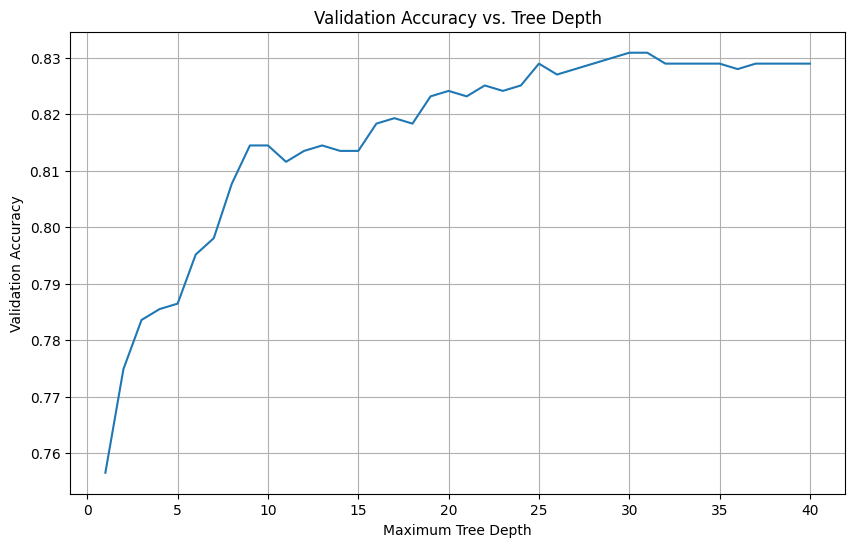

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=246810)

depths = list(range(1, 41))
val_accuracies = []

for depth in depths:
    dt = DecisionTree(max_depth=depth, feature_labels=features)
    dt.fit(X_train, y_train)


    val_predictions = np.array([dt.predict(x) for x in X_val])
    val_acc = accuracy_score(y_val, val_predictions)
    val_accuracies.append(val_acc)


best_depth = depths[np.argmax(val_accuracies)]
best_accuracy = max(val_accuracies)


plt.figure(figsize=(10, 6))
plt.plot(depths, val_accuracies)
plt.xlabel('Maximum Tree Depth')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Tree Depth')
plt.grid(True)


print(f"Best depth: {best_depth}")
print(f"Best validation accuracy: {best_accuracy:.4f}")

plt.show()


# New Section